In [1]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras


**Задача:** создать модель машинного обучения для классификации питомцев : кошек и собак (dataset = cats_and_dogs_filtered.zip ).
Выбираем предварительно обученную модель для использования. Рассмотрим архитектуру Xception, обученную на наборе данных ImageNet.


In [2]:
# Распаковка набора данных и указание пути к обучающему и проверочному набору.
with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
base_dir = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [3]:
# Загружаем изображения

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(150, 150))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


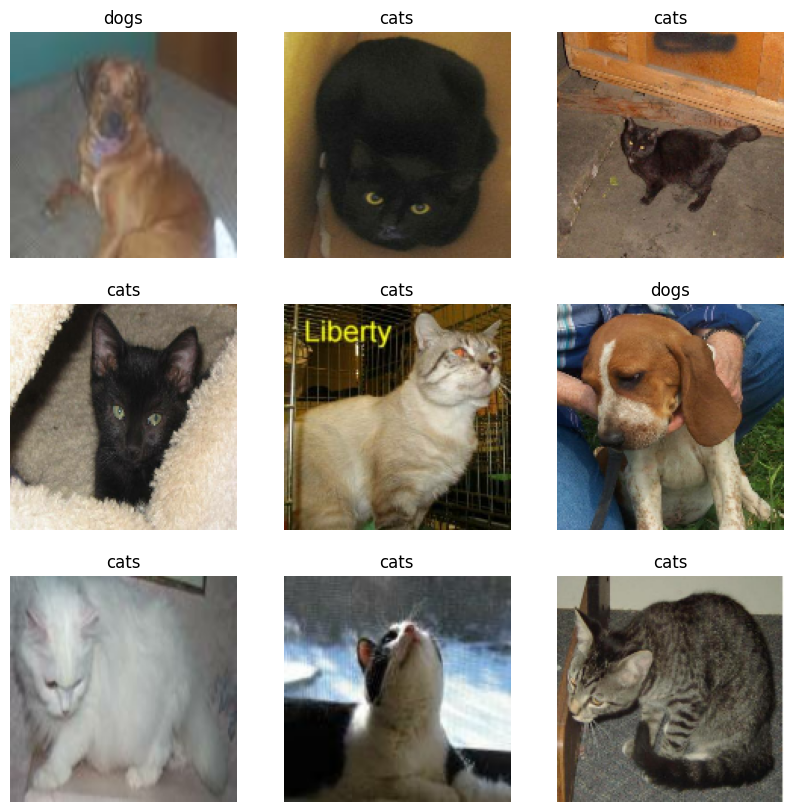

In [4]:
# Смотреть 10 изображений и меток из обучающего набора
class_names = training_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
   
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
#Создание тестового набора данных
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
validation_dataset = val_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
# Настроить набор данных для производительности

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = training_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data pre-processing

In [7]:

data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

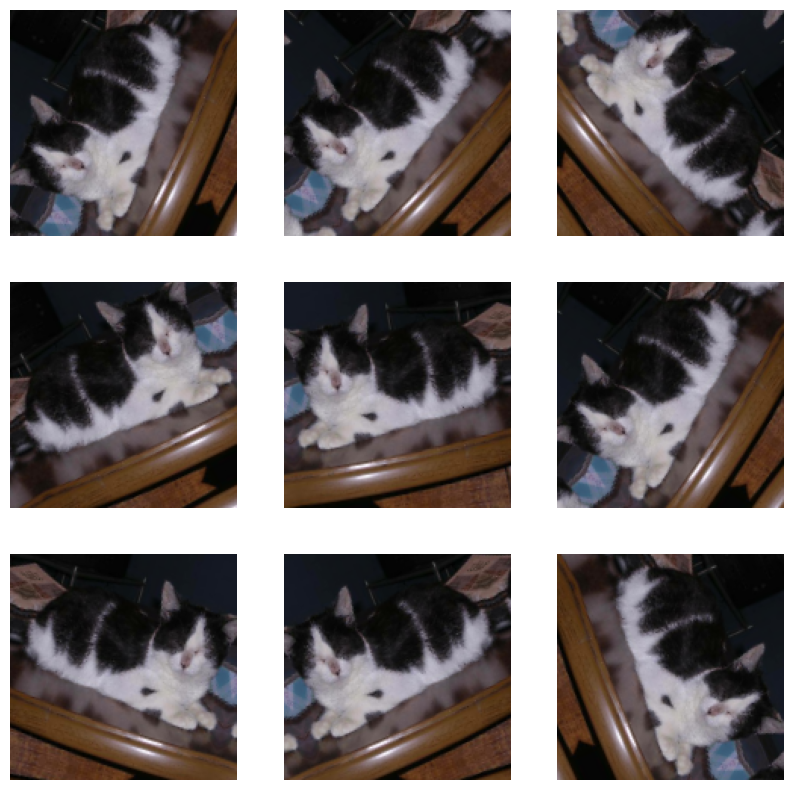

In [8]:
# Применение аугументации к одному и тому же избражению

for image, _ in training_set.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Feature Extraction

In [9]:
# Изменение масштаба значений пикселей
preprocess_input = tf.keras.applications.xception.preprocess_input


In [10]:
# Создание базовой модели на основе предварительно обученной модели Xception
# Загружаем в модель веса, обученные на ImageNet
# Финальный слой не используем
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)  

In [11]:
# Преобразовать каждое изображение 150x150x3 в блок функций 5x5x2048
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [12]:
# Заморозка слоев базовой модели, чтобы они не обновлялись в процессе обучения. 
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [13]:
# Преобразовать функции в один вектор из 2048 элементов для каждого изображения 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [14]:
# Финальный слой
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(150,150,3))
x=data_augmentation(inputs)
x = preprocess_input(x)
# Базовая модель работает в режиме вывода
x = base_model(x, training=False)

# Преобразование признаков из базовой модели в векторы
x = global_average_layer(x)

# Применение регуляризации Drpout
x = keras.layers.Dropout(0.2)(x)

# Добавление финального слоя
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [16]:
#Скомпилируем модель
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            
            metrics = ['accuracy'])

In [17]:
len(model.trainable_variables)

2

In [18]:
# Возвращает значения потерь и метрики для модели в проверочном режиме
loss0,accuracy0 = model.evaluate(validation_dataset)




26/26 [==============================] - 53s 2s/step - loss: 0.9871 - accuracy: 0.2649


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.99
initial accuracy: 0.26


In [20]:
initial_epochs = 10
history = model.fit(training_set, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 175s 3s/step - loss: 0.7759 - accuracy: 0.4955 - val_loss: 0.6142 - val_accuracy: 0.6547
Epoch 2/10
63/63 [==============================] - 160s 3s/step - loss: 0.5500 - accuracy: 0.7015 - val_loss: 0.4084 - val_accuracy: 0.7995
Epoch 3/10
63/63 [==============================] - 154s 2s/step - loss: 0.4287 - accuracy: 0.7955 - val_loss: 0.3045 - val_accuracy: 0.8837
Epoch 4/10
63/63 [==============================] - 148s 2s/step - loss: 0.3689 - accuracy: 0.8210 - val_loss: 0.2397 - val_accuracy: 0.9245
Epoch 5/10
63/63 [==============================] - 160s 3s/step - loss: 0.3181 - accuracy: 0.8605 - val_loss: 0.2072 - val_accuracy: 0.9369
Epoch 6/10
63/63 [==============================] - 162s 3s/step - loss: 0.2951 - accuracy: 0.8700 - val_loss: 0.1858 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 160s 3s/step - loss: 0.2814 - accuracy: 0.8735 - val_loss: 0.1692 - val_accuracy: 0.9431
Epoch 8/10
63/63 [======

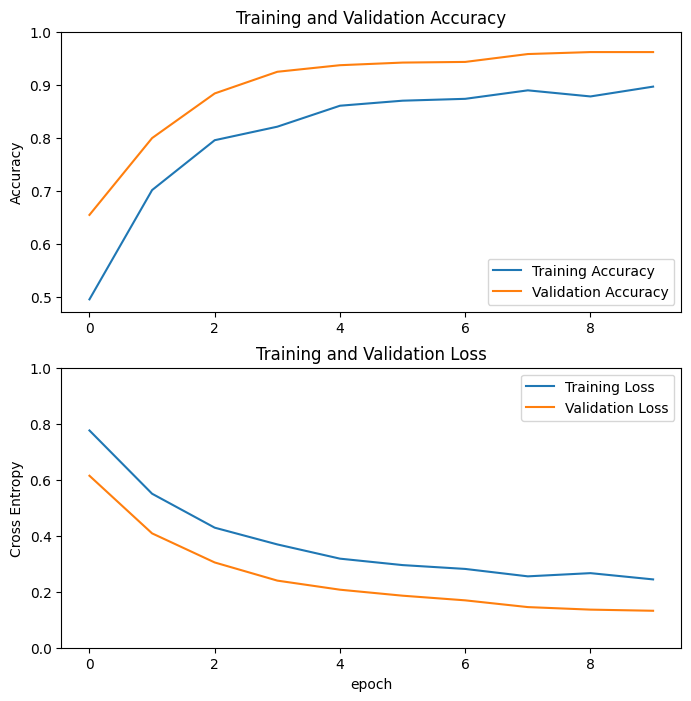

In [21]:
# Построение кривых обучения

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning the model

In [22]:
# Размораживание базовой модели
base_model.trainable = True

In [23]:

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [24]:
# Разморизить слои с 80 слоя
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
#rm -rf logs
%load_ext tensorboard
log_folder = 'logs'

callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

In [29]:
new_epochs = 10
total_epochs = initial_epochs+new_epochs
history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks)

Epoch 10/20
63/63 [==============================] - 255s 4s/step - loss: 0.1884 - accuracy: 0.9145 - val_loss: 0.0735 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 238s 4s/step - loss: 0.1414 - accuracy: 0.9405 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 235s 4s/step - loss: 0.1287 - accuracy: 0.9470 - val_loss: 0.0610 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 238s 4s/step - loss: 0.1221 - accuracy: 0.9500 - val_loss: 0.0547 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 238s 4s/step - loss: 0.1101 - accuracy: 0.9545 - val_loss: 0.0606 - val_accuracy: 0.9740
Epoch 15/20
63/63 [==============================] - 251s 4s/step - loss: 0.0944 - accuracy: 0.9625 - val_loss: 0.0577 - val_accuracy: 0.9802
Epoch 16/20
63/63 [==============================] - 249s 4s/step - loss: 0.0901 - accuracy: 0.9590 - val_loss: 0.0585 - val_accuracy: 0.9790
Epoch 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

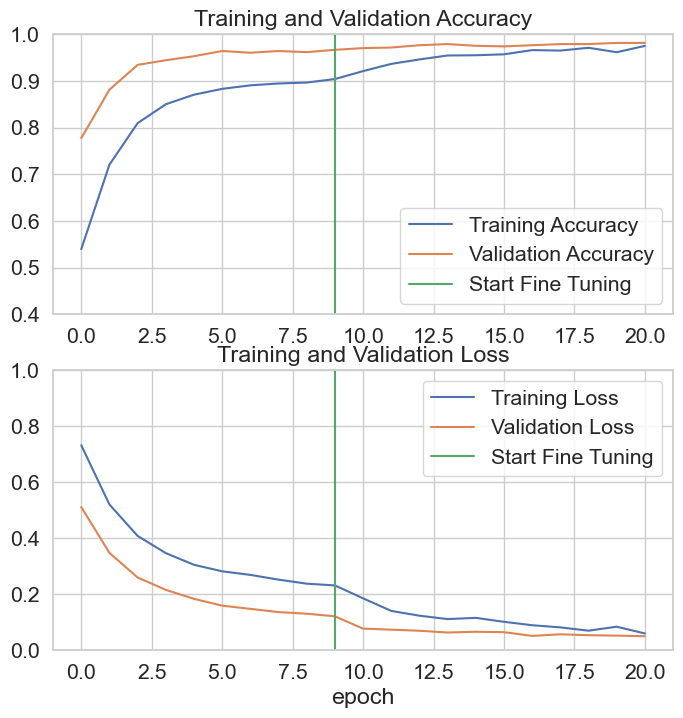

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Оценка и прогноз

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 11s 2s/step - loss: 0.0186 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0]
Labels:
 [1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0]


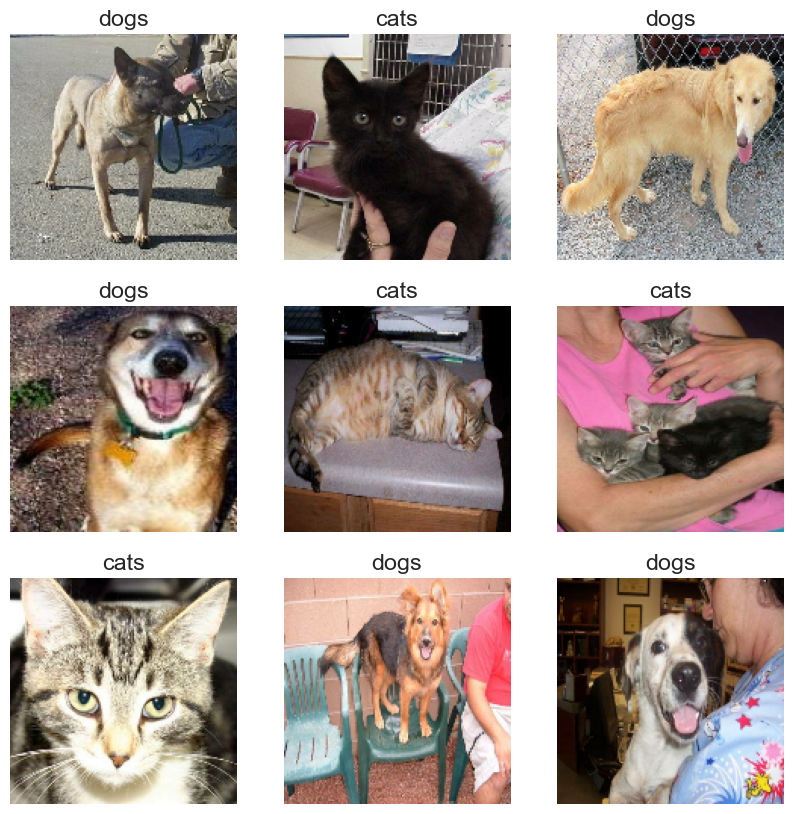

In [ ]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:

from tensorflow.keras.preprocessing import image

img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)




1/1 [==============================] - 0s 110ms/step


In [ ]:
rt=decode_predictions(preds, top=3)[0]
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02089078', 'black-and-tan_coonhound', 0.3893617), ('n02107142', 'Doberman', 0.30111423), ('n02105412', 'kelpie', 0.21758884)]


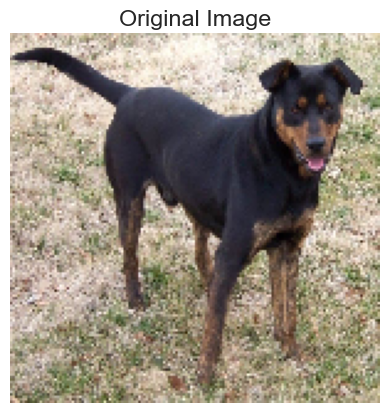

In [ ]:
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()